In [1]:
import h5py
import argparse
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from scipy.spatial.transform import Slerp
from mpl_toolkits.mplot3d import Axes3D

import robomimic
import robomimic.utils.obs_utils as ObsUtils
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.file_utils as FileUtils

from waypoint_extraction.traj_reconstruction import (
    pos_only_geometric_waypoint_trajectory,
    reconstruct_waypoint_trajectory,
    geometric_waypoint_trajectory,
)
from utils import plot_3d_trajectory



/home/sen/anaconda3/envs/robodiff/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def dp_waypoint_selection(
    gt_states=None,
    pos_only=False,
):
    if gt_states is None:
        raise ValueError("gt_states must be provided")
        
    num_frames = len(gt_states)
    err_threshold = 0.005  # Fixed error threshold as per requirement

    # make the last frame a waypoint
    initial_waypoints = [num_frames - 1]

    # make the frames of gripper open/close waypoints
    if not pos_only:
        for i in range(num_frames - 1):
            if gt_states[i, -1] != gt_states[i + 1, -1]:
                initial_waypoints.append(i)
        initial_waypoints.sort()

    # Memoization table to store the waypoint sets for subproblems
    memo = {}

    # Initialize the memoization table
    for i in range(num_frames):
        memo[i] = (0, [])

    memo[1] = (1, [1])
    func = (
        pos_only_geometric_waypoint_trajectory
        if pos_only
        else geometric_waypoint_trajectory
    )

    # Check if err_threshold is too small, then return all points as waypoints
    min_error = func(gt_states, gt_states, list(range(1, num_frames)))
    if err_threshold < min_error:
        print("Error threshold is too small, returning all points as waypoints.")
        return list(range(1, num_frames))

    # Populate the memoization table using an iterative bottom-up approach
    for i in range(1, num_frames):
        min_waypoints_required = float("inf")
        best_waypoints = []

        for k in range(1, i):
            # waypoints are relative to the subsequence
            waypoints = [j - k for j in initial_waypoints if j >= k and j < i] + [i - k]

            total_traj_err = func(
                actions=gt_states[k : i + 1],
                gt_states=gt_states[k : i + 1],
                waypoints=waypoints,
            )

            if total_traj_err < err_threshold:
                subproblem_waypoints_count, subproblem_waypoints = memo[k - 1]
                total_waypoints_count = 1 + subproblem_waypoints_count

                if total_waypoints_count < min_waypoints_required:
                    min_waypoints_required = total_waypoints_count
                    best_waypoints = subproblem_waypoints + [i]

        memo[i] = (min_waypoints_required, best_waypoints)

    min_waypoints_count, waypoints = memo[num_frames - 1]
    waypoints += initial_waypoints
    # remove duplicates
    waypoints = list(set(waypoints))
    waypoints.sort()
    print(
        f"Minimum number of waypoints: {len(waypoints)} \tTrajectory Error: {total_traj_err}"
    )
    #print(f"waypoint positions: {waypoints}")

    return waypoints

In [3]:
gt_eef = np.loadtxt("/home/sen/Desktop/awe/plot/epsilon/square_ground_truth_pos.txt")
print("gt eef shape:", gt_eef.shape)

gt eef shape: (123, 3)


In [ ]:
waypoints = dp_waypoint_selection(gt_eef, pos_only=True)

In [6]:
waypoints = [0] + waypoints
waypoint_states = [gt_eef[i] for i in waypoints]
waypoint_states = np.array(waypoint_states)
print(waypoint_states.shape)

(15, 3)


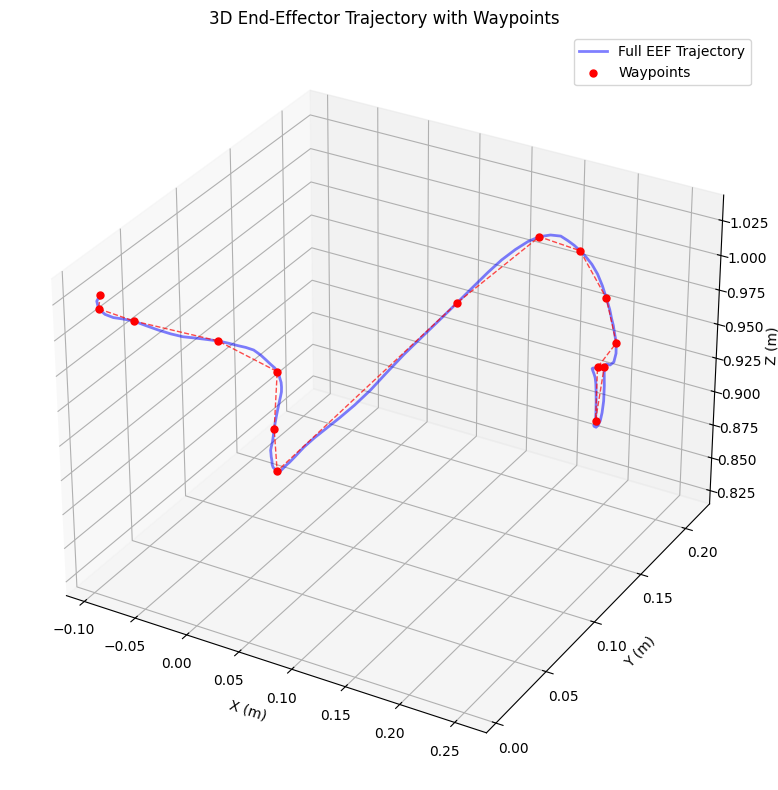

In [7]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the full trajectory
ax.plot(
    gt_eef[:, 0], gt_eef[:, 1], gt_eef[:, 2],
    label='Full EEF Trajectory', 
    color='blue', 
    linewidth=2.0,
    alpha=0.5
)

# Plot waypoints as red dots
ax.scatter(
    waypoint_states[:, 0], waypoint_states[:, 1], waypoint_states[:, 2],
    label='Waypoints', 
    color='red', 
    s=25, 
    depthshade=False,
    edgecolors='red'
)

# Connect waypoints with a dashed red line
ax.plot(
    waypoint_states[:, 0], waypoint_states[:, 1], waypoint_states[:, 2],
    color='red', 
    linestyle='--', 
    linewidth=1,
    alpha=0.7
)

# Add labels and legend
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D End-Effector Trajectory with Waypoints')
ax.legend()

plt.tight_layout()
plt.show()

In [8]:
def spline_waypoint_trajectory(
    actions, # Dummy to maintain similiarty to original function of awe
    gt_states, # Ground truth states i.e., recorded trajecoty
    waypoints, # Selected keyfram indices
    pos_only=False, # If true only compare 3D pos x, y, z, otherwise compare full states
    return_list=False, # If true return list, including mean error
    degree=3 # Spline degree default = 3 meaning cubic 
):
    # Handles edge case: need at least 2 waypoints to make spline 
    # If less than 2 spline not possible return inf error meaning worst case 
    if len(waypoints) < 2:
        return float('inf')
    
    # Convert waypoint indices to np.array
    waypoint_timesteps = np.array(waypoints)
    # Extract state values from trajecory at iter index k in waypoints
    waypoint_values = np.array([gt_states[k] for k in waypoints])
    
    # Adjust spline degree if we don't have enough points
    # Example: Can't do cubic (degree=3) with only 3 points (need degree ≤ points-1)
    effective_degree = min(degree, len(waypoints) - 1)
    
    try:
        # Create the spline that interpolates between waypoints
        spline = make_interp_spline(
            waypoint_timesteps, # X-axis: timestep indices
            waypoint_values, # Y-axis: state values at those timesteps
            k=effective_degree,  # Degree of the spline (adjusted if needed)
            axis=0, # Interpolate along first axis (time dimension)
            check_finite=True # Make sure all values are finite numbers
        )
    except ValueError:
        # If spline creation fails (bad math), return infinity error
        return float('inf')
    
    # Evaluate the spline at EVERY timestep to get complete trajectory
    spline_traj = spline(np.arange(len(gt_states)))
    # Calculate errors between spline and ground truth
    if pos_only:
        # Only compare first 3 elements (x,y,z position)
        errors = np.mean((spline_traj[:, :3] - gt_states[:, :3])**2, axis=1)
    else:
        # Compare full state (position + orientation + velocity etc.)
        errors = np.mean((spline_traj - gt_states)**2, axis=1)
    
    # Return either just the mean error OR (mean + full error list)
    return np.mean(errors) if not return_list else (np.mean(errors), errors.tolist())

In [9]:
def dp_waypoint_selection_spline(
    gt_states=None, # Ground truth trajectory (required)
    pos_only=False, # If True, only optimize for position (ignore orientation/velocity)
    err_threshold=0.005, # Max allowed error between spline and ground truth
    degree=3  # Degree of the spline (e.g., 3 = cubic spline)
):
    # Input validation
    if gt_states is None:
        raise ValueError("gt_states must be provided")
    
    num_frames = len(gt_states)
    initial_waypoints = [0, num_frames - 1]  # Always include first and last frames


    # If not position-only, detect gripper state changes (e.g., open/close events)
    if not pos_only:
        for i in range(num_frames - 1):
            if gt_states[i, -1] != gt_states[i + 1, -1]:
                initial_waypoints.append(i) # Add frames where gripper state changes
        initial_waypoints = sorted(list(set(initial_waypoints))) # Remove duplicates

    # Check if the error threshold is achievable (lower bound: error when using ALL frames)
    min_error = spline_waypoint_trajectory(
        gt_states, gt_states, list(range(num_frames)), pos_only, degree=degree
    )
    if err_threshold < min_error:
        print("Error threshold too small. Using all frames.")
        return list(range(num_frames)) # Fallback: return every frame if threshold is impossibl

    # Dynamic Programming (DP) setup:
    # memo[i] stores (min_waypoints_needed, best_waypoint_list) for the subproblem up to frame i
    memo = {0: (0, [0])} # Base case: 0 waypoints needed for the first frame
    
    for i in range(1, num_frames): # Solve subproblems for each frame 1..N-1
        min_waypoints = float('inf') # Initialize to worst case
        best_waypoints = []

        # Try all possible split points (k) to reuse previous solutions
        for k in range(i):
            # Get best solution up to frame k
            _, prev_waypoints = memo.get(k, (float('inf'), []))
            # Candidate waypoints: previous waypoints + current frame + mandatory waypoints
            candidate_waypoints = sorted(list(set(prev_waypoints + [i] + initial_waypoints)))
            # Extract waypoints relevant to the current segment (frames k to i)
            segment_waypoints = [wp for wp in candidate_waypoints if wp >= k and wp <= i]
            
            # Ensure enough points for the chosen degree (degree+1 points needed)
            if len(segment_waypoints) < degree + 1:
                # If not, add evenly spaced points (fallback)
                segment_waypoints = [k + j for j in range(degree + 1) if k + j <= i]
                if len(segment_waypoints) < 2: # Edge case: at least 2 points needed
                    segment_waypoints = [k, i]
            
            # Compute error for this segment
            error = spline_waypoint_trajectory(
                actions=gt_states[k:i+1], # Unused (placeholder) - Dummy for interface
                gt_states=gt_states[k:i+1], # Ground truth for segment
                waypoints=[wp - k for wp in segment_waypoints], # Relative indices
                pos_only=pos_only,
                degree=degree  # Pass degree to spline fitting
            )

            # Update DP table if this split is better
            if error <= err_threshold and (len(prev_waypoints) + 1) < min_waypoints:
                min_waypoints = len(prev_waypoints) + 1
                best_waypoints = prev_waypoints + [i] # New best solution

        memo[i] = (min_waypoints, best_waypoints) # Store solution for frame i
    
    # Final result: combine DP solution with mandatory waypoints
    final_waypoints = sorted(list(set(memo[num_frames-1][1] + initial_waypoints)))

    # Compute final error for validation
    final_error = spline_waypoint_trajectory(
        gt_states, gt_states, final_waypoints, pos_only, degree=degree
    )
    print(f"Selected {len(final_waypoints)} waypoints | Error: {final_error:.6f} | Degree: {degree}")
    return final_waypoints

In [10]:
spline_waypoints = dp_waypoint_selection_spline(gt_eef, err_threshold=0.0005, pos_only=True, degree=3)

Selected 14 waypoints | Error: 0.000007 | Degree: 3


In [12]:
spline_waypoints_states = [gt_eef[i] for i in spline_waypoints]
spline_waypoints_states = np.array(spline_waypoints_states)
print(spline_waypoints_states.shape)

(14, 3)


In [13]:
timesteps = np.array(waypoints)
states = np.array([gt_eef[i] for i in waypoints])
spline = make_interp_spline(timesteps, states, k=3, axis=0)
    
# Evaluate spline at high resolution
fine_t = np.linspace(0, len(gt_eef)-1, 1000)
spline_traj = spline(fine_t)

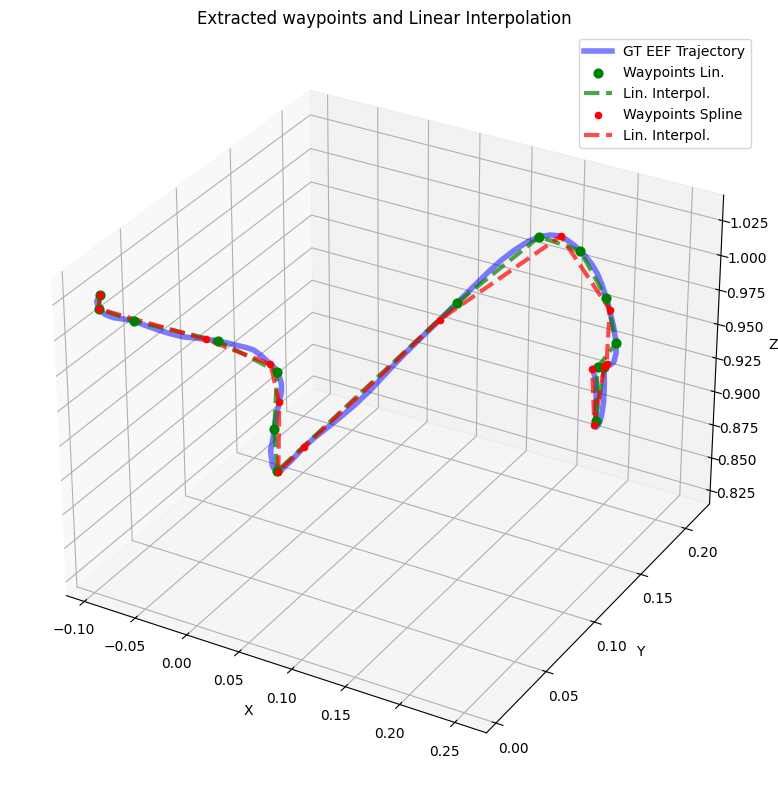

In [14]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the full trajectory
ax.plot(
    gt_eef[:, 0], gt_eef[:, 1], gt_eef[:, 2],
    label='GT EEF Trajectory', 
    color='blue', 
    linewidth=4.0,
    alpha=.5 
)

# linear
# Plot waypoints as red dots
ax.scatter(
    waypoint_states[:, 0], waypoint_states[:, 1], waypoint_states[:, 2],
    label='Waypoints Lin.', 
    color='green', 
    s=40,
    depthshade=False,
    edgecolors='green' 
)

# Connect waypoints
ax.plot(
    waypoint_states[:, 0], waypoint_states[:, 1], waypoint_states[:, 2],
    label = 'Lin. Interpol.',
    color='green', 
    linestyle='--', 
    linewidth=3.0,
    alpha=0.7
)

# spline
# Plot waypoints as red dots
ax.scatter(
    spline_waypoints_states[:, 0], spline_waypoints_states[:, 1], spline_waypoints_states[:, 2],
    label='Waypoints Spline', 
    color='red', 
    s=20,  
    depthshade=False,
    edgecolors='red' 
)

# Connect waypoints
ax.plot(
    spline_waypoints_states[:, 0], spline_waypoints_states[:, 1], spline_waypoints_states[:, 2],
    label = 'Lin. Interpol.',
    color='red', 
    linestyle='--', 
    linewidth=3,
    alpha=0.7
)

# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Extracted waypoints and Linear Interpolation')
ax.legend()


plt.tight_layout()
plt.show()

NameError: name 'reconstructed_traj' is not defined

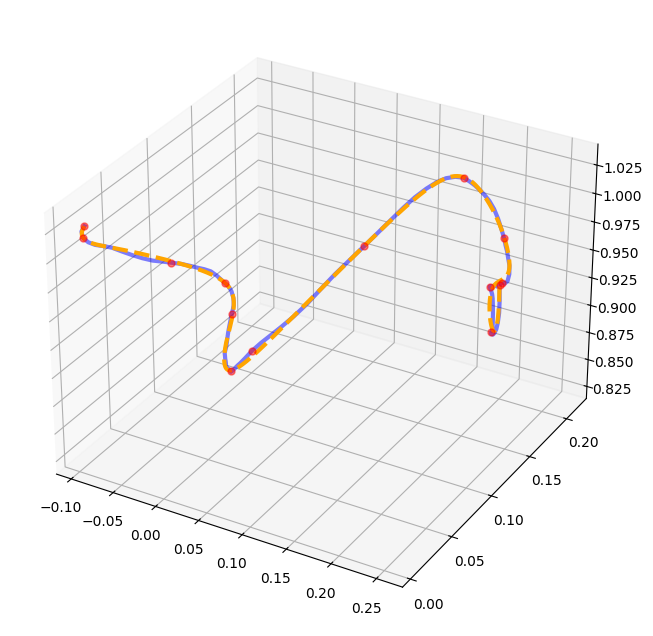

In [15]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the full trajectory
ax.plot(
    gt_eef[:, 0], gt_eef[:, 1], gt_eef[:, 2],
    label='GT EEF Trajectory', 
    color='blue', 
    linewidth=3.0,
    alpha=0.5  
)

# spline
# Plot waypoints as red dots i.e., scatter
ax.scatter(
    spline_waypoints_states[:, 0], spline_waypoints_states[:, 1], spline_waypoints_states[:, 2],
    label='Waypoints Spline', 
    color='red', 
    s=25, 
    depthshade=False,
    edgecolors='red',
    alpha=0.5
)

# Connect waypoints
#ax.plot(
#    spline_waypoints_states[:, 0], spline_waypoints_states[:, 1], spline_waypoints_states[:, 2],
#    label='Lin. Interpol.',
#    color='red', 
#    linestyle='--',
#    linewidth=1.5,
#    alpha=0.75
#)


# Connect waypoints 
ax.plot(
    spline_traj[:, 0], spline_traj[:, 1], spline_traj[:, 2],
    label='Fitted Spline',
    color='orange', 
    linestyle='--',
    linewidth=3.0,
    alpha=1.0
)


ax.plot(
    reconstructed_traj[:, 0], reconstructed_traj[:, 1], reconstructed_traj[:, 2],
    label='Recon. Spline',
    color='green', 
    linestyle='--',
    linewidth=3.0,
    alpha=1.0
)



# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Fitted Spline and Reconstruction based on Waypoints')
ax.legend()

plt.tight_layout()
plt.show()

In [107]:
gt_eef.shape

(123, 3)

In [ ]:
spline_waypoints_states

In [109]:
spline_waypoints_states.shape

(14, 3)

In [108]:
reconstructed_traj.shape

(260, 3)

NameError: name 'reconstructed_traj' is not defined

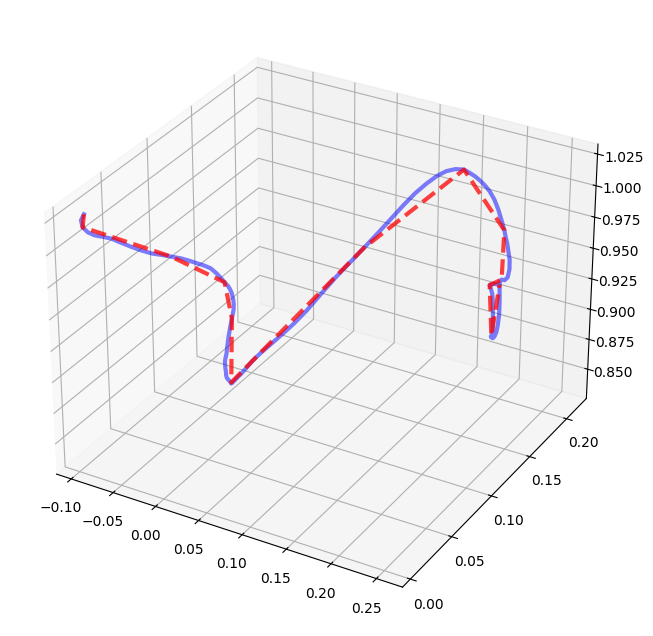

In [16]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the full trajectory
ax.plot(
    gt_eef[:, 0], gt_eef[:, 1], gt_eef[:, 2],
    label='GT EEF Trajectory', 
    color='blue', 
    linewidth=3.0,
    alpha=0.5  
)

# spline
# Plot waypoints as red dots i.e., scatter
#ax.scatter(
#    spline_waypoints_states[:, 0], spline_waypoints_states[:, 1], spline_waypoints_states[:, 2],
#    label='Waypoints Spline', 
#    color='red', 
#    s=25, 
#    depthshade=False,
#    edgecolors='red',
#    alpha=0.5
#)

# Connect waypoints with a dashed red line
ax.plot(
    spline_waypoints_states[:, 0], spline_waypoints_states[:, 1], spline_waypoints_states[:, 2],
    label='Lin. Interpol.',
    color='red', 
    linestyle='--',
    linewidth=3.0,
    alpha=0.75
)


# Connect waypoints
#ax.plot(
#    spline_traj[:, 0], spline_traj[:, 1], spline_traj[:, 2],
#    label='Fitted Spline',
#    color='orange', 
#    linestyle='--',
#    linewidth=3.0,
#    alpha=1.0
#)


ax.plot(
    reconstructed_traj[:, 0], reconstructed_traj[:, 1], reconstructed_traj[:, 2],
    label='Recon. Spline',
    color='green', 
    linestyle='--',
    linewidth=3.0,
    alpha=1.0
)



# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Ground Truth Trajecoty: Reconstructed Spline vs. Linear')
ax.legend()

plt.tight_layout()
plt.show()

In [17]:
import numpy as np
from scipy.interpolate import interp1d

def resample_trajectory(trajectory, n_points=100):
    """Resample a trajectory to a fixed number of points using linear interpolation."""
    original_length = len(trajectory)
    original_indices = np.linspace(0, 1, original_length)
    new_indices = np.linspace(0, 1, n_points)
    
    interpolator = interp1d(original_indices, trajectory, axis=0, kind='linear')
    resampled_traj = interpolator(new_indices)
    return resampled_traj

# Resample all trajectories to 100 points
gt_eef_resampled = resample_trajectory(gt_eef, n_points=100)
spline_waypoints_resampled = resample_trajectory(spline_waypoints_states, n_points=100)
reconstructed_resampled = resample_trajectory(reconstructed_traj, n_points=100)

# Compute errors
def compute_3d_error(traj1, traj2):
    """Compute MAE and RMSE between two trajectories."""
    error = np.linalg.norm(traj1 - traj2, axis=1)
    mae = np.mean(error)
    rmse = np.sqrt(np.mean(error ** 2))
    return mae, rmse

mae_linear, rmse_linear = compute_3d_error(gt_eef_resampled, spline_waypoints_resampled)
mae_recon, rmse_recon = compute_3d_error(gt_eef_resampled, reconstructed_resampled)

print(f"Linear Interpolation vs. GT: MAE = {mae_linear:.4f}, RMSE = {rmse_linear:.4f}")
print(f"Reconstructed Spline vs. GT: MAE = {mae_recon:.4f}, RMSE = {rmse_recon:.4f}")

NameError: name 'reconstructed_traj' is not defined

In [ ]:
def plot_3d_spline(gt_states, waypoints, degree=3):
    """Plot ground truth, spline, and waypoints in 3D."""
    # Fit spline to waypoints
    timesteps = np.array(waypoints)
    states = np.array([gt_states[i] for i in waypoints])
    spline = make_interp_spline(timesteps, states, k=degree, axis=0)
    
    # Evaluate spline at high resolution
    fine_t = np.linspace(0, len(gt_states)-1, 1000)
    spline_traj = spline(fine_t)

    # Create 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot ground truth (thin blue line)
    ax.plot(gt_states[:, 0], gt_states[:, 1], gt_states[:, 2], 
            'b-', alpha=0.3, label='Ground Truth')
    
    # Plot spline (thick red dashed line)
    ax.plot(spline_traj[:, 0], spline_traj[:, 1], spline_traj[:, 2], 
            'r--', linewidth=2, label=f'Spline (Degree={degree})')
    
    # Plot waypoints (red dots)
    ax.scatter(states[:, 0], states[:, 1], states[:, 2], 
               c='red', s=50, label='Waypoints')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.title('3D Trajectory and Spline Fit')
    plt.show()



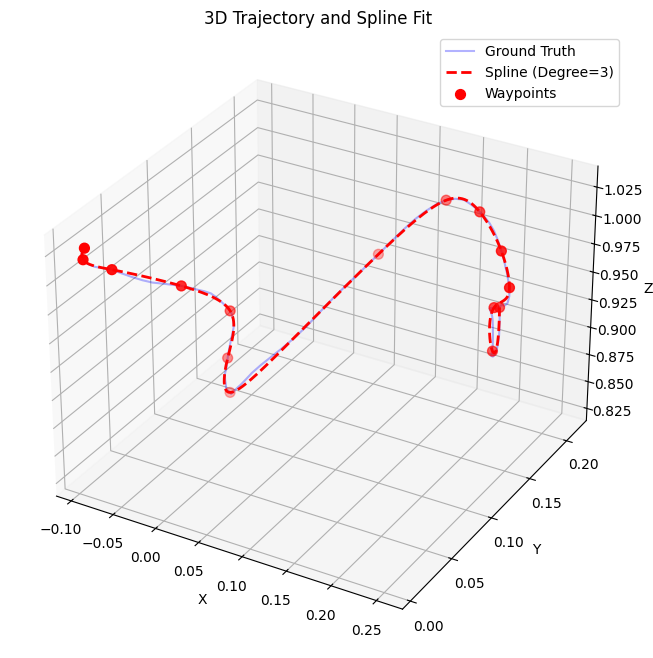

In [19]:
plot_3d_spline(gt_eef, waypoints, degree=3)

In [20]:
derivatives_waypoints

array([[-1.11614076e-03,  1.75423873e-05, -5.15355146e-03],
       [ 1.44139758e-05,  6.91459184e-04, -4.86956212e-03],
       [ 3.34132887e-03,  5.07644670e-03, -4.64817566e-03],
       [ 1.84416584e-04,  4.09305627e-03, -5.19908651e-03],
       [-1.17846618e-03,  1.66176475e-03, -4.39387364e-03],
       [ 9.92758665e-05,  9.79616393e-04, -1.01556704e-03],
       [ 5.63541576e-03,  4.16414044e-03,  5.53832729e-03],
       [ 1.05915376e-02,  3.43163065e-03,  8.89439046e-03],
       [ 1.11876986e-02, -2.61068484e-03,  4.38216965e-03],
       [ 4.75731969e-03, -2.82595990e-03, -2.64650536e-03],
       [-1.37072840e-03,  5.59310712e-04, -3.29099474e-03],
       [-1.37172317e-03,  7.39558900e-04, -2.81723728e-03],
       [ 4.49519344e-05,  6.68919560e-04,  9.81624961e-05],
       [-2.13345491e-04,  1.25109430e-03,  3.81882717e-03]])

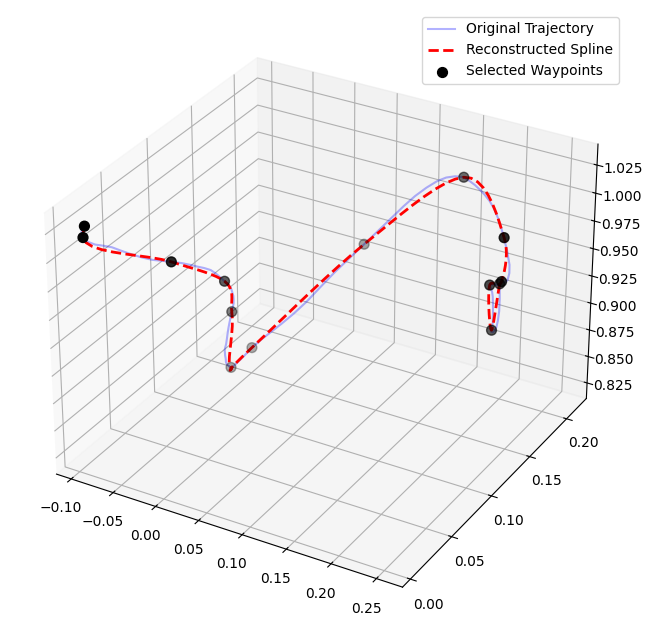

In [18]:
# 1. Create time array for waypoints (using original timestep indices)
t_waypoints = np.array(spline_waypoints)

# 2. Estimate derivatives at waypoints using finite differences
derivatives_waypoints = np.gradient(spline_waypoints_states, t_waypoints, axis=0)

# 3. Reconstruction function for individual segments
def reconstruct_segment_with_derivatives(start_idx, end_idx):
    """Reconstruct spline between two consecutive waypoints"""
    # Get boundary conditions
    t_start = t_waypoints[start_idx]
    t_end = t_waypoints[end_idx]
    p_start = spline_waypoints_states[start_idx]
    p_end = spline_waypoints_states[end_idx]
    deriv_start = derivatives_waypoints[start_idx]
    deriv_end = derivatives_waypoints[end_idx]
    
    # Create clamped spline segment
    return make_interp_spline(
        [t_start, t_end],
        np.vstack([p_start, p_end]),
        k=3,
        bc_type=([(1, deriv_start)], [(1, deriv_end)]),
        axis=0
    )

# 4. Reconstruct full trajectory
reconstructed_traj = []
for i in range(len(t_waypoints)-1):
    # Create segment spline
    seg_spline = reconstruct_segment_with_derivatives(i, i+1)
    
    # Generate dense points for this segment
    t_seg = np.linspace(t_waypoints[i], t_waypoints[i+1], 10)
    reconstructed_traj.append(seg_spline(t_seg))

reconstructed_traj = np.vstack(reconstructed_traj)

# 5. Plot comparison
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Original trajectory
ax.plot(gt_eef[:, 0], gt_eef[:, 1], gt_eef[:, 2], 
        'b-', alpha=0.3, label='Original Trajectory')

# Reconstructed spline
ax.plot(reconstructed_traj[:, 0], reconstructed_traj[:, 1], reconstructed_traj[:, 2], 
        'r--', lw=2, label='Reconstructed Spline')

# Waypoints
ax.scatter(spline_waypoints_states[:, 0], spline_waypoints_states[:, 1], spline_waypoints_states[:, 2],
           c='k', s=50, zorder=10, label='Selected Waypoints')

ax.legend()
plt.show()

In [98]:
gt_eef.shape

(123, 3)

In [99]:
t_original.shape

(123,)

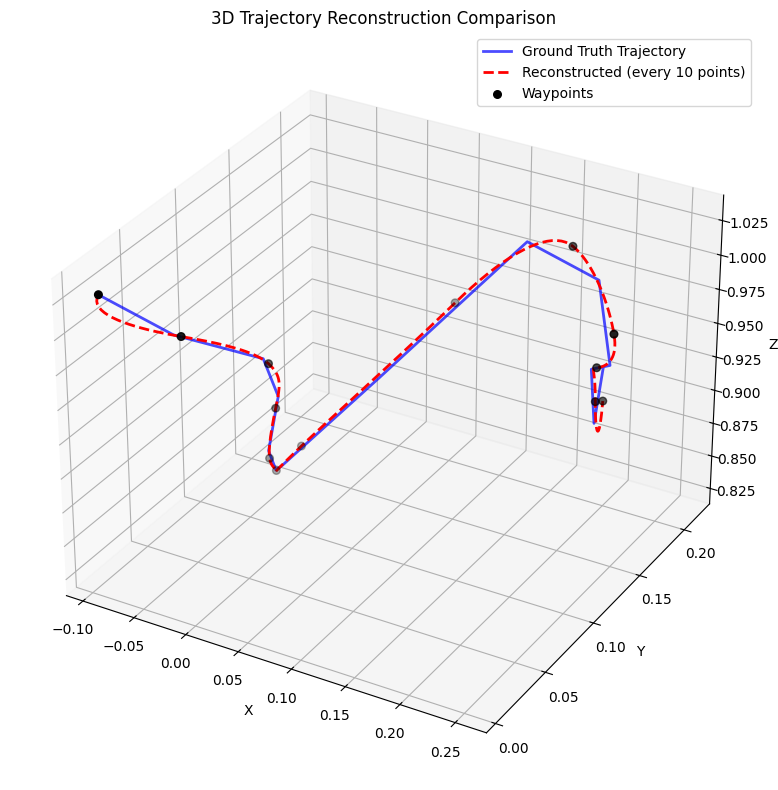

In [ ]:
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

# Load your ground truth trajectory
gt_eef = np.loadtxt("/home/sen/Desktop/awe/plot/epsilon/square_ground_truth_pos.txt")

# Create a time array based on the number of points
t_original = np.linspace(0, gt_eef.shape[0]-1, gt_eef.shape[0])

# 1. Fit original 3D spline (cubic)
spline_original = make_interp_spline(t_original, gt_eef, k=3)
t_dense = np.linspace(t_original[0], t_original[-1], 500)  # More points for smooth plot
original_traj_dense = spline_original(t_dense)

# 2. Finite difference derivatives (for reconstruction)
derivatives = np.gradient(gt_eef, t_original, axis=0)

# 3. Reconstruction function for 3D
def reconstruct_3d_segment(p_start, p_end, deriv_start, deriv_end, t_start, t_end, k=3):
    """Reconstruct 3D spline segment between two points with derivatives."""
    return make_interp_spline(
        [t_start, t_end],
        np.vstack([p_start, p_end]),
        k=k,
        bc_type=([(1, deriv_start)], [(1, deriv_end)]),  # Clamped derivatives
        axis=0
    )

# 4. Reconstruct all segments - let's use every 10th point to make it more visible
step = 10  # Adjust this to change how many points you use for reconstruction
reconstructed_traj = []
for i in range(0, len(t_original)-step, step):
    seg_spline = reconstruct_3d_segment(
        p_start=gt_eef[i],
        p_end=gt_eef[i+step],
        deriv_start=derivatives[i],
        deriv_end=derivatives[i+step],
        t_start=t_original[i],
        t_end=t_original[i+step],
        k=3
    )
    t_seg = np.linspace(t_original[i], t_original[i+step], 20)  # Points per segment
    reconstructed_traj.append(seg_spline(t_seg))

reconstructed_traj = np.vstack(reconstructed_traj)

# 5. 3D Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Original trajectory
ax.plot(original_traj_dense[:, 0], original_traj_dense[:, 1], original_traj_dense[:, 2], 
        'b-', lw=2, alpha=0.7, label='Ground Truth Trajectory')

# Reconstructed trajectory
ax.plot(reconstructed_traj[:, 0], reconstructed_traj[:, 1], reconstructed_traj[:, 2], 
        'r--', lw=2, label=f'Reconstructed (every {step} points)')

# Waypoints (using the same step as reconstruction)
ax.scatter(gt_eef[::step, 0], gt_eef[::step, 1], gt_eef[::step, 2], 
           c='k', s=30, label='Waypoints')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title('3D Trajectory Reconstruction Comparison')
plt.tight_layout()
plt.show()

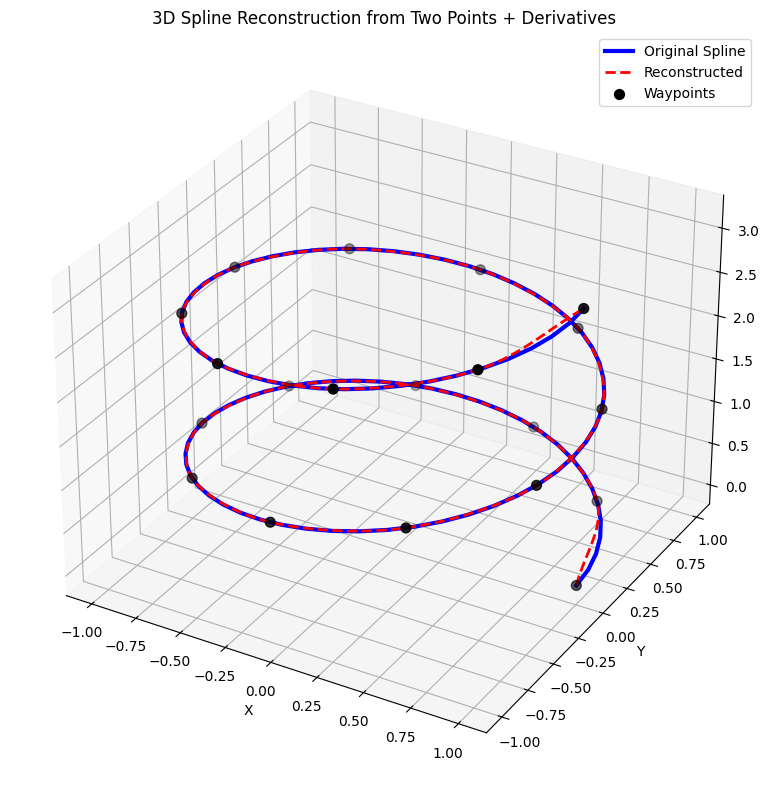

In [21]:
# 1. Generate original 3D trajectory (helix example)
t_original = np.linspace(0, 4*np.pi, 20)
x_original = np.cos(t_original)
y_original = np.sin(t_original)
z_original = t_original / 4
original_traj = np.column_stack((x_original, y_original, z_original))

# 2. Fit original 3D spline (cubic)
spline_original = make_interp_spline(t_original, original_traj, k=3)
t_dense = np.linspace(t_original[0], t_original[-1], 100)
original_traj_dense = spline_original(t_dense)

# 3. Finite difference derivatives (for reconstruction)
derivatives = np.gradient(original_traj, t_original, axis=0)

# 4. Reconstruction function for 3D
def reconstruct_3d_segment(p_start, p_end, deriv_start, deriv_end, t_start, t_end, k=3):
    """Reconstruct 3D spline segment between two points with derivatives."""
    return make_interp_spline(
        [t_start, t_end],
        np.vstack([p_start, p_end]),
        k=k,
        bc_type=([(1, deriv_start)], [(1, deriv_end)]),  # Clamped derivatives
        axis=0
    )

# 5. Reconstruct all segments
reconstructed_traj = []
for i in range(len(t_original) - 1):
    seg_spline = reconstruct_3d_segment(
        p_start=original_traj[i],
        p_end=original_traj[i+1],
        deriv_start=derivatives[i],
        deriv_end=derivatives[i+1],
        t_start=t_original[i],
        t_end=t_original[i+1],
        k=3
    )
    t_seg = np.linspace(t_original[i], t_original[i+1], 10)
    reconstructed_traj.append(seg_spline(t_seg))

reconstructed_traj = np.vstack(reconstructed_traj)

# 6. 3D Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Original trajectory
ax.plot(original_traj_dense[:, 0], original_traj_dense[:, 1], original_traj_dense[:, 2], 
        'b-', lw=3, label='Original Spline')

# Reconstructed trajectory
ax.plot(reconstructed_traj[:, 0], reconstructed_traj[:, 1], reconstructed_traj[:, 2], 
        'r--', lw=2, label='Reconstructed')

# Waypoints
ax.scatter(original_traj[:, 0], original_traj[:, 1], original_traj[:, 2], 
           c='k', s=50, label='Waypoints')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title('3D Spline Reconstruction from Two Points + Derivatives')
plt.tight_layout()
plt.show()

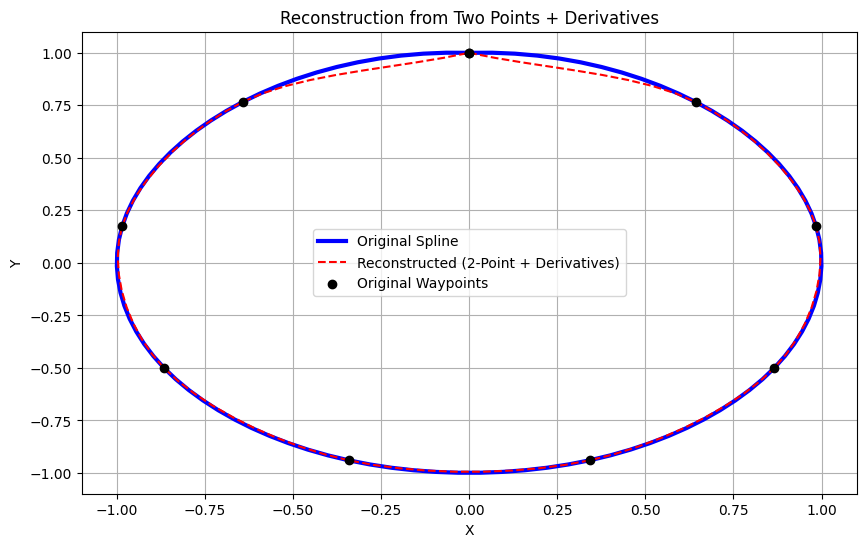

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(original_traj_dense[:, 0], original_traj_dense[:, 1], 'b-', lw=3, label='Original Spline')
plt.plot(reconstructed_traj[:, 0], reconstructed_traj[:, 1], 'r--', label='Reconstructed (2-Point + Derivatives)')
plt.scatter(original_traj[:, 0], original_traj[:, 1], c='k', label='Original Waypoints', zorder=3)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.title('Reconstruction from Two Points + Derivatives')
plt.show()

In [6]:
# Load your data
gt_eef = np.loadtxt("/home/sen/Desktop/awe/plot/epsilon/square_ground_truth_pos.txt")
print("Loaded trajectory shape:", gt_eef.shape)  # Should be (123, 3)

# 1. Create time array (assuming uniform timesteps)
t_original = np.linspace(0, 1, len(gt_eef))

# 2. Fit original spline (cubic)
spline_original = make_interp_spline(t_original, gt_eef, k=3, axis=0)
t_dense = np.linspace(t_original[0], t_original[-1], 500)
original_traj_dense = spline_original(t_dense)

# 3. Compute derivatives (velocity)
derivatives = np.gradient(gt_eef, t_original, axis=0)

# 4. Reconstruct from consecutive point pairs + derivatives
reconstructed_segments = []
for i in range(len(t_original) - 1):
    # Create segment spline with boundary derivatives
    seg_spline = make_interp_spline(
        [t_original[i], t_original[i+1]],
        np.array([gt_eef[i], gt_eef[i+1]]),
        k=3,
        bc_type=([(1, derivatives[i])], [(1, derivatives[i+1])]),  # Clamped derivatives
        axis=0
    )
    # Evaluate segment
    t_seg = np.linspace(t_original[i], t_original[i+1], 10)
    reconstructed_segments.append(seg_spline(t_seg))

reconstructed_traj = np.vstack(reconstructed_segments)

# 5. Calculate errors
mse = np.mean(np.linalg.norm(original_traj_dense[:len(reconstructed_traj)] - reconstructed_traj, axis=1))
max_error = np.max(np.linalg.norm(original_traj_dense[:len(reconstructed_traj)] - reconstructed_traj, axis=1))

print(f"Reconstruction Errors:")
print(f"- MSE: {mse:.6f}")
print(f"- Max deviation: {max_error:.6f}")

# 6. Plotting
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

# Original trajectory
ax.plot(original_traj_dense[:, 0], original_traj_dense[:, 1], original_traj_dense[:, 2], 
        'b-', lw=2, alpha=0.7, label='Original Spline')

# Reconstructed trajectory
ax.plot(reconstructed_traj[:, 0], reconstructed_traj[:, 1], reconstructed_traj[:, 2], 
        'r--', lw=1.5, label='Reconstructed (2-point segments)')

# Waypoints (every 10th point for clarity)
ax.scatter(gt_eef[::10, 0], gt_eef[::10, 1], gt_eef[::10, 2], 
           c='k', s=30, label='Waypoints')

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.legend()
plt.title('3D End-Effector Trajectory Reconstruction\n(MSE: {:.4f}, Max Error: {:.4f})'.format(mse, max_error))
plt.tight_layout()
plt.show()

Loaded trajectory shape: (123, 3)


ValueError: operands could not be broadcast together with shapes (500,3) (1220,3) 